## Portfolio Allocation and Optimization: Monte Carlo Simulation and Optimization Algorithm

Uptil now we were focused more on analysing and forcasting Stock prices for Individual Stocks. A trader or a Hedge fund manager can optimize their Trading strategies based on the forcast Buy/Sell signal. 
We will now act as a Portfolio Manager and try to build a Trading Strategy using Sharpe Ratio and Optimization to demonstrate how a Portfolio can be optimized for higher gains. 

### Sharpe Ratio

The Sharpe ratio measures the performance of an investment compared to a risk-free asset, after adjusting for its risk. It is defined as the difference between the returns of the investment and the risk-free return, divided by the standard deviation of the investment. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import seaborn as sns
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from keras.optimizers import RMSprop, SGD, Adam
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
%matplotlib inline

os.chdir(r'N:\STOCK ADVISOR BOT')


In [24]:
mcd = pd.read_csv('MCD.csv')
#best features
features_selected = ['Date','Close(t)']
mcd = mcd[features_selected]
mcd = mcd.iloc[3500:-60, :]
mcd = mcd.rename(columns={'Close(t)':'Close'})
mcd = mcd.set_index('Date')
mcd

,Close
Date,
2018-09-12,164.74
2018-09-13,162.40
2018-09-14,160.84
2018-09-17,158.14
2018-09-18,157.77
...,...
2020-01-14,207.32
2020-01-15,209.77
2020-01-16,210.85


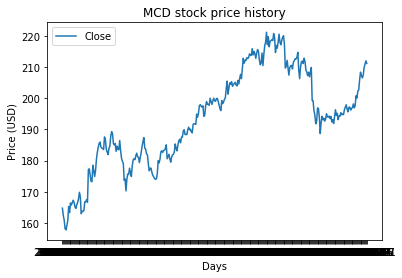

In [25]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(mcd["Close"])
plt.title('MCD stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Close'], loc='upper left')
plt.show()

### Lets get the Stock prices for 3 more stocks (Coka cola , Goldman Sachs and Johnsons & Johnsons) 

In [28]:
gs = pd.read_csv('GS.csv')
#best features
features_selected = ['Date','Close(t)']
gs = gs[features_selected]
gs = gs.iloc[3500:-60, :]
gs = gs.rename(columns={'Close(t)':'Close'})
gs = gs.set_index('Date')


jnj = pd.read_csv('JNJ.csv')
#best features
features_selected = ['Date','Close(t)']
jnj = jnj[features_selected]
jnj = jnj.iloc[3500:-60, :]
jnj = jnj.rename(columns={'Close(t)':'Close'})
jnj = jnj.set_index('Date')


ko = pd.read_csv('KO.csv')
#best features
features_selected = ['Date','Close(t)']
ko = ko[features_selected]
ko = ko.iloc[3500:-60, :]
ko = ko.rename(columns={'Close(t)':'Close'})
ko = ko.set_index('Date')

In [29]:
for stock_df in (mcd, ko, gs, jnj): 
    stock_df['Normed Return'] = stock_df['Close'] /stock_df.iloc[0]['Close']

### Normalized returns 

In [30]:
jnj.head()

,Close,Normed Return
Date,,
2018-09-12,139.36,1.000000
2018-09-13,139.89,1.003803
2018-09-14,139.49,1.000933
2018-09-17,139.96,1.004305
2018-09-18,140.54,1.008467


In [31]:
ko.head()

,Close,Normed Return
Date,,
2018-09-12,46.24,1.000000
2018-09-13,45.83,0.991133
2018-09-14,45.99,0.994593
2018-09-17,46.32,1.001730
2018-09-18,45.93,0.993296


### Portfolio Allocation

Let take the starting Portfolio Allocations consisting of these 4 stocks as - 

- 25% in MCD
- 10% in KO
- 30% in JNJ
- 35% in GS

In [32]:
for stock_df, allo in zip((mcd, ko, jnj, gs),[.25,.1,.3,.35]):
    stock_df['Allocation'] = stock_df['Normed Return']*allo

In [33]:
mcd.head()

,Close,Normed Return,Allocation
Date,,,
2018-09-12,164.74,1.000000,0.250000
2018-09-13,162.40,0.985796,0.246449
2018-09-14,160.84,0.976326,0.244082
2018-09-17,158.14,0.959937,0.239984
2018-09-18,157.77,0.957691,0.239423


 Assuming the starting portfolio Position of 1 million $, lets look at how the value of our position changes in each stock

In [34]:
# value of each position
for stock_df in (mcd, ko, jnj, gs):
    stock_df['Position Value'] = stock_df['Allocation']*1000000

In [36]:
gs.head(10)

,Close,Normed Return,Allocation,Position Value
Date,,,,
2018-09-12,228.15,1.000000,0.350000,350000.000000
2018-09-13,228.33,1.000789,0.350276,350276.134122
2018-09-14,229.24,1.004778,0.351672,351672.145518
2018-09-17,227.89,0.998860,0.349601,349601.139601
2018-09-18,228.89,1.003243,0.351135,351135.218058
2018-09-19,235.58,1.032566,0.361398,361398.202937
2018-09-20,237.40,1.040544,0.364190,364190.225729
2018-09-21,235.34,1.031514,0.361030,361030.024107
2018-09-24,232.90,1.020820,0.357287,357286.872671


You can see how the value in increasing. Lets create a single dataframe for all of the 4 stocks

In [37]:
# create list of all position values
all_pos_vals = [mcd['Position Value'], ko['Position Value'], jnj['Position Value'], gs['Position Value']]

# concatenate the list of position values
portfolio_val = pd.concat(all_pos_vals, axis=1)

# set the column names
portfolio_val.columns = ['MCD', 'KO', 'JNJ', 'GS']

# add a total portfolio column
portfolio_val['Total'] = portfolio_val.sum(axis=1)

In [38]:
portfolio_val.head(10)

,MCD,KO,JNJ,GS,Total
Date,,,,,
2018-09-12,250000.000000,100000.000000,300000.000000,350000.000000,1.000000e+06
2018-09-13,246448.949860,99113.321799,301140.929966,350276.134122,9.969793e+05
2018-09-14,244081.583101,99459.342561,300279.850746,351672.145518,9.954929e+05
2018-09-17,239984.217555,100173.010381,301291.618829,349601.139601,9.910500e+05
2018-09-18,239422.726721,99329.584775,302540.183697,351135.218058,9.924277e+05
2018-09-19,241562.462061,99394.463668,302367.967853,361398.202937,1.004723e+06
2018-09-20,244005.705961,100865.051903,305640.068886,364190.225729,1.014701e+06
2018-09-21,250849.823965,100735.294118,307577.497130,361030.024107,1.020193e+06
2018-09-24,247829.913804,99632.352941,302389.494834,357286.872671,1.007139e+06


### we can see day-by-day how our positions and portfolio value is changing.

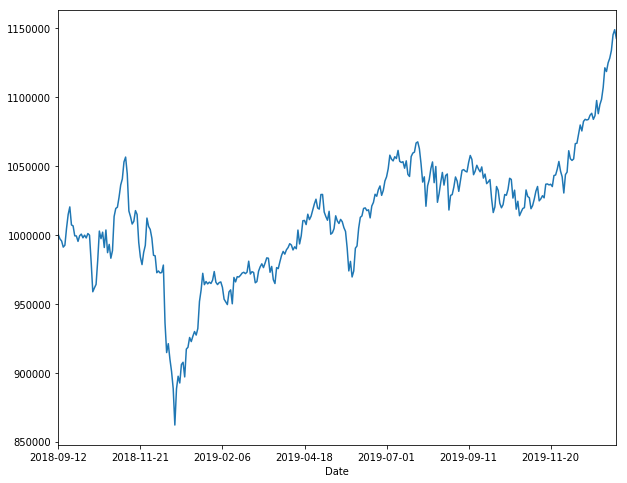

In [39]:
# plot our portfolio
import matplotlib.pyplot as plt
%matplotlib inline
portfolio_val['Total'].plot(figsize=(10,8))

### We have made 150k for the year

Lets also look at individual contributions of each stock in our portfolio

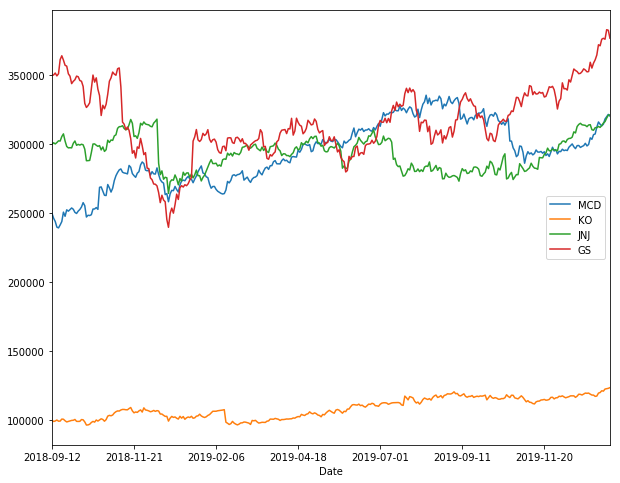

In [40]:
portfolio_val.drop('Total',axis=1).plot(figsize=(10,8))

### Let's move towards implementing MCMC and Optimization

In [41]:
# Daily Return
portfolio_val['Daily Return'] = portfolio_val['Total'].pct_change(1)

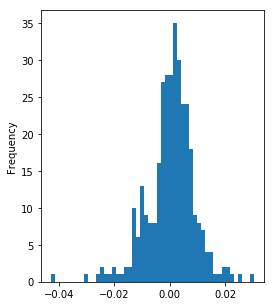

In [43]:
# average daily return
portfolio_val['Daily Return'].mean()

# standard deviation
portfolio_val['Daily Return'].std()

# plot histogram of daily returns
portfolio_val['Daily Return'].plot(kind='hist', bins=50, figsize=(4,5))

Calculating the total portfolio return 

In [45]:
# cumulative portfolio return
cum_return = 100 * (portfolio_val['Total'][-1]/portfolio_val['Total'][0] - 1)
cum_return

14.233819436382689

### Calculate Sharpe Ratio

The Sharpe Ratio is the mean (portfolio return - the risk free rate) % standard deviation.

In [47]:
sharpe_ratio = portfolio_val['Daily Return'].mean() / portfolio_val['Daily Return'].std()
ASR = (252**0.5) * sharpe_ratio
ASR

0.7923843343475722

Annualized Share Ratio is 0.79

### Optimization using Monte Carlo Simulation

We will check a bunch of random allocations and analyse which one has the best Sharpe Ratio.
#### This process of randomly guessing is known as a Monte Carlo Simulation.

We will randomly assign weights to our stocks in the portfolio using mcmc and then calculate the average daily return & SD (Standard deviation) of return. Then we can calculate the Sharpe Ratio for many randomly selected allocations. 

We will further use Optimzation Algorithm to minimize for this. 

Minimization is a similar concept to optimization - let's say we have a simple equation y = x2 - the idea is we're trying to figure out what value of x will minimize y, in this example 0.

This idea of a minimizer will allow us to build an optimizer.

In [52]:
# concatenate them and rename the columns
stocks = pd.concat([mcd.Close, ko.Close, gs.Close, jnj.Close], axis=1)
stocks.columns = ['MCD', 'KO', 'GS', 'JNJ']
stocks

,MCD,KO,GS,JNJ
Date,,,,
2018-09-12,164.74,46.24,228.15,139.36
2018-09-13,162.40,45.83,228.33,139.89
2018-09-14,160.84,45.99,229.24,139.49
2018-09-17,158.14,46.32,227.89,139.96
2018-09-18,157.77,45.93,228.89,140.54
...,...,...,...,...
2020-01-14,207.32,56.00,245.66,146.52
2020-01-15,209.77,56.70,245.21,147.01
2020-01-16,210.85,56.82,249.72,148.20


In [53]:
stocks.pct_change(1).mean()

MCD    0.000787
KO     0.000682
GS     0.000350
JNJ    0.000274
dtype: float64

In [54]:
stocks.pct_change(1).head()

,MCD,KO,GS,JNJ
Date,,,,
2018-09-12,NaN,NaN,NaN,NaN
2018-09-13,-0.014204,-0.008867,0.000789,0.003803
2018-09-14,-0.009606,0.003491,0.003985,-0.002859
2018-09-17,-0.016787,0.007175,-0.005889,0.003369
2018-09-18,-0.002340,-0.008420,0.004388,0.004144


In [55]:
# log daily return
log_return = np.log(stocks/stocks.shift(1))
log_return.head()

,MCD,KO,GS,JNJ
Date,,,,
2018-09-12,NaN,NaN,NaN,NaN
2018-09-13,-0.014306,-0.008906,0.000789,0.003796
2018-09-14,-0.009652,0.003485,0.003978,-0.002863
2018-09-17,-0.016929,0.007150,-0.005906,0.003364
2018-09-18,-0.002342,-0.008455,0.004378,0.004135


In [57]:
print(stocks.columns)

weights = np.array(np.random.random(4))
print('Random Weights:')
print(weights)

print('Rebalance')
weights = weights/np.sum(weights)
print(weights)

Index(['MCD', 'KO', 'GS', 'JNJ'], dtype='object')
Random Weights:
[0.21954447 0.44098201 0.70431503 0.66102909]
Rebalance
[0.10837043 0.21767531 0.34766042 0.32629384]


In [58]:
# expected return
print('Expected Portfolio Return')
exp_ret = np.sum((log_return.mean()*weights)*252)
print(exp_ret)

# expected volatility
print('Expected Volatility')
exp_vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252, weights)))
print(exp_vol)

# Sharpe Ratio
print('Sharpe Ratio')
SR = exp_ret/exp_vol
print(SR)

Expected Portfolio Return
0.08988210291523915
Expected Volatility
0.141941703080142
Sharpe Ratio
0.6332325240911801


Now we will repeat the above process over 1000 times 

In [63]:
num_ports = 8000
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports): 
    # weights 
    weights = np.array(np.random.random(4)) 
    weights = weights/np.sum(weights)  
    # save the weights
    all_weights[ind,:] = weights
    # expected return 
    ret_arr[ind] = np.sum((log_return.mean()*weights)*252)

    # expected volatility 
    vol_arr[ind] = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252, weights)))

    # Sharpe Ratio 
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [64]:
sharpe_arr.max()

1.232583481117841

If we then get the location of the maximum Sharpe Ratio and then get the allocation for that index. This shows us the optimal allocation out of the 8000 random allocations:

In [65]:
sharpe_arr.argmax()

7098

In [66]:
all_weights[7098, :]

array([0.5435089, 0.4213097, 0.0333299, 0.0018515])

These are the best allocations we have received using MCMC. Lets compare how we did from the original Allocation

Original Allocation - 

- 25% in MCD
- 10% in KO
- 30% in JNJ
- 35% in GS

MCMC Allocation - 

- 54% in MCD
- 42% in KO
- 3% in JNJ
- 0.1% IN gs


### Initial Allocation

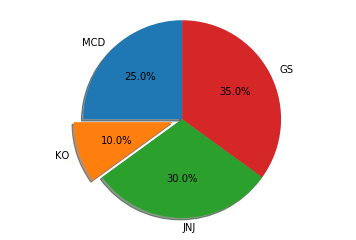

In [68]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'MCD', 'KO', 'JNJ', 'GS'
sizes = [25, 10, 30, 35]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### After MCMC

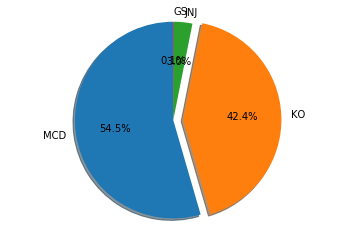

In [69]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'MCD', 'KO', 'JNJ', 'GS'
sizes = [54, 42, 3, 0.1]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### Portfolio Optimization: Optimization Algorithm
Let's now move on from random allocations to a mathematical optimization algorithm.

All of the heavy lifting for this optimization will be done with SciPy, so we just have to do a few things to set up the optimization function.

In [85]:
from scipy.optimize import minimize

def get_ret_vol_sr(weights): 
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T,np.dot(log_return .cov()*252,weights)))
    sr = ret/vol 
    return np.array([ret,vol,sr])


# minimize negative Sharpe Ratio
def neg_sharpe(weights): 
    return get_ret_vol_sr(weights)[2] * -1

# check allocation sums to 1
def check_sum(weights): 
    return np.sum(weights) - 1

In [81]:
# create constraint variable
cons = ({'type':'eq','fun':check_sum})

In [82]:
# create weight boundaries
bounds = ((0,1),(0,1),(0,1),(0,1))

In [83]:
# initial guess
init_guess = [0.25, 0.25, 0.25, 0.25]

First we call minimize and pass in what we're trying to minimize - negative Sharpe, our initial guess, we set the minimization method to SLSQP, and we set our bounds and constraints:

In [86]:
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

In [87]:
opt_results

     fun: -1.2367256869326764
     jac: array([ 7.86781311e-05, -1.11460686e-04,  2.17465907e-02,  1.84697896e-01])
 message: 'Optimization terminated successfully.'
    nfev: 24
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([5.86101757e-01, 4.13898243e-01, 0.00000000e+00, 7.91467586e-17])

In [88]:
opt_results.x

array([5.86101757e-01, 4.13898243e-01, 0.00000000e+00, 7.91467586e-17])

In [89]:
get_ret_vol_sr(opt_results.x)

array([0.17293204, 0.13983055, 1.23672569])

The Optimal results of the Optimization algorithm are 1.2367

### Conclusion 

We have implemented Monte carlo Simulation technique to randomly take a sample and simulate it to find the best sharpe ratio for a given portfolio. 
Then we moved to a better appraoch using Optimization Algorithm by Minimize function in Spicy library. 

We get around same Sharpe ratio for both which improves on the initial portfolio allocation we started off with. 

We can form more trading strategies based on other methods too like Pairs trading, Butterfly spread, Bull-bear spread etc. But we just wanted to implement a Trading strategy and see how we can optimize a portfolio. 

### License
MIT License

Copyright (c) 2020 Nikhil Kohli

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.